In [5]:
import utils
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch
from dataset import DataSet
import os

import sys
sys.path.insert(0, '/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/')

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preview KL Annealing Schedule

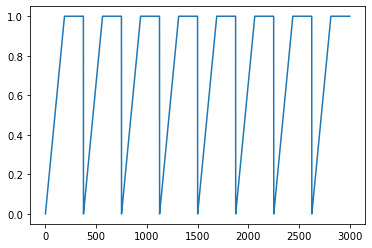

In [7]:
plt.plot(utils.frange_cycle_linear(3000, n_cycle=8))

### Preview Mistaken kl sched

In [8]:
''' we had 4 cycles across 20,000 iterations and 1-6 represent the pauses
we took and when beta param for KL was accidently reset'''
x = utils.frange_cycle_linear(20000, n_cycle=4)
one = x[:570]
two = x[:60]
three = x[:60]
four = x[:180]
five = x[:30]
six = x[:390]

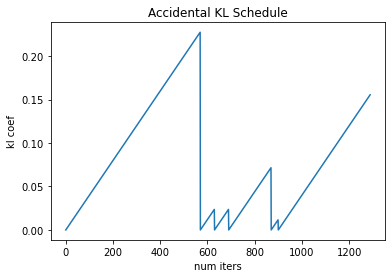

In [9]:
plt.plot(np.concatenate((one,two,three,four,five,six)))
plt.xlabel('num iters')
plt.ylabel('kl coef')
plt.title('Accidental KL Schedule')
plt.savefig('img/errkl')

In [112]:
lcs = utils.get_data(folder='../datasets/ZTF_all', start_col=1, min_length=1, shuffle=True)

validated 3407 files out of 3407 for band='r'
validated 3407 files out of 3407 for band='i'
validated 3408 files out of 3408 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (2683, 3, 4431, 3)
train size: 2414, valid size: 242, test size: 269


In [190]:
def preview_lcs(lcs, n=1, figsize=(15,15)):
    dims = lcs.dataset.shape[1]
    fig, ax = plt.subplots(n, dims, figsize=figsize, squeeze=False)
    fig.tight_layout(pad=5.0)
    for i in range(n):
        obj_name = lcs.valid_files_df.index.values[i]
        ax[i][0].set_title(obj_name,fontsize=fs)
        for band in range(dims):
            t = lcs.dataset[i,band,:,0]
            y = lcs.dataset[i,band,:,1]
            yerr = lcs.dataset[i,band,:,2]
            pts = y.nonzero()[0]
            ax[i][band].errorbar(t[pts],y[pts], yerr=yerr[pts], c='blue', fmt='.', markersize=4, ecolor='red', elinewidth=1, capsize=2)
    lines_labels = ax[0][0].get_legend_handles_labels()
    lines,labels = lines_labels[0], lines_labels[1]
    fig.legend(lines, labels, loc='upper left')
    [ax[i][index].set_xlabel(lcs.bands[index]) for index in range(len(lcs.bands))]

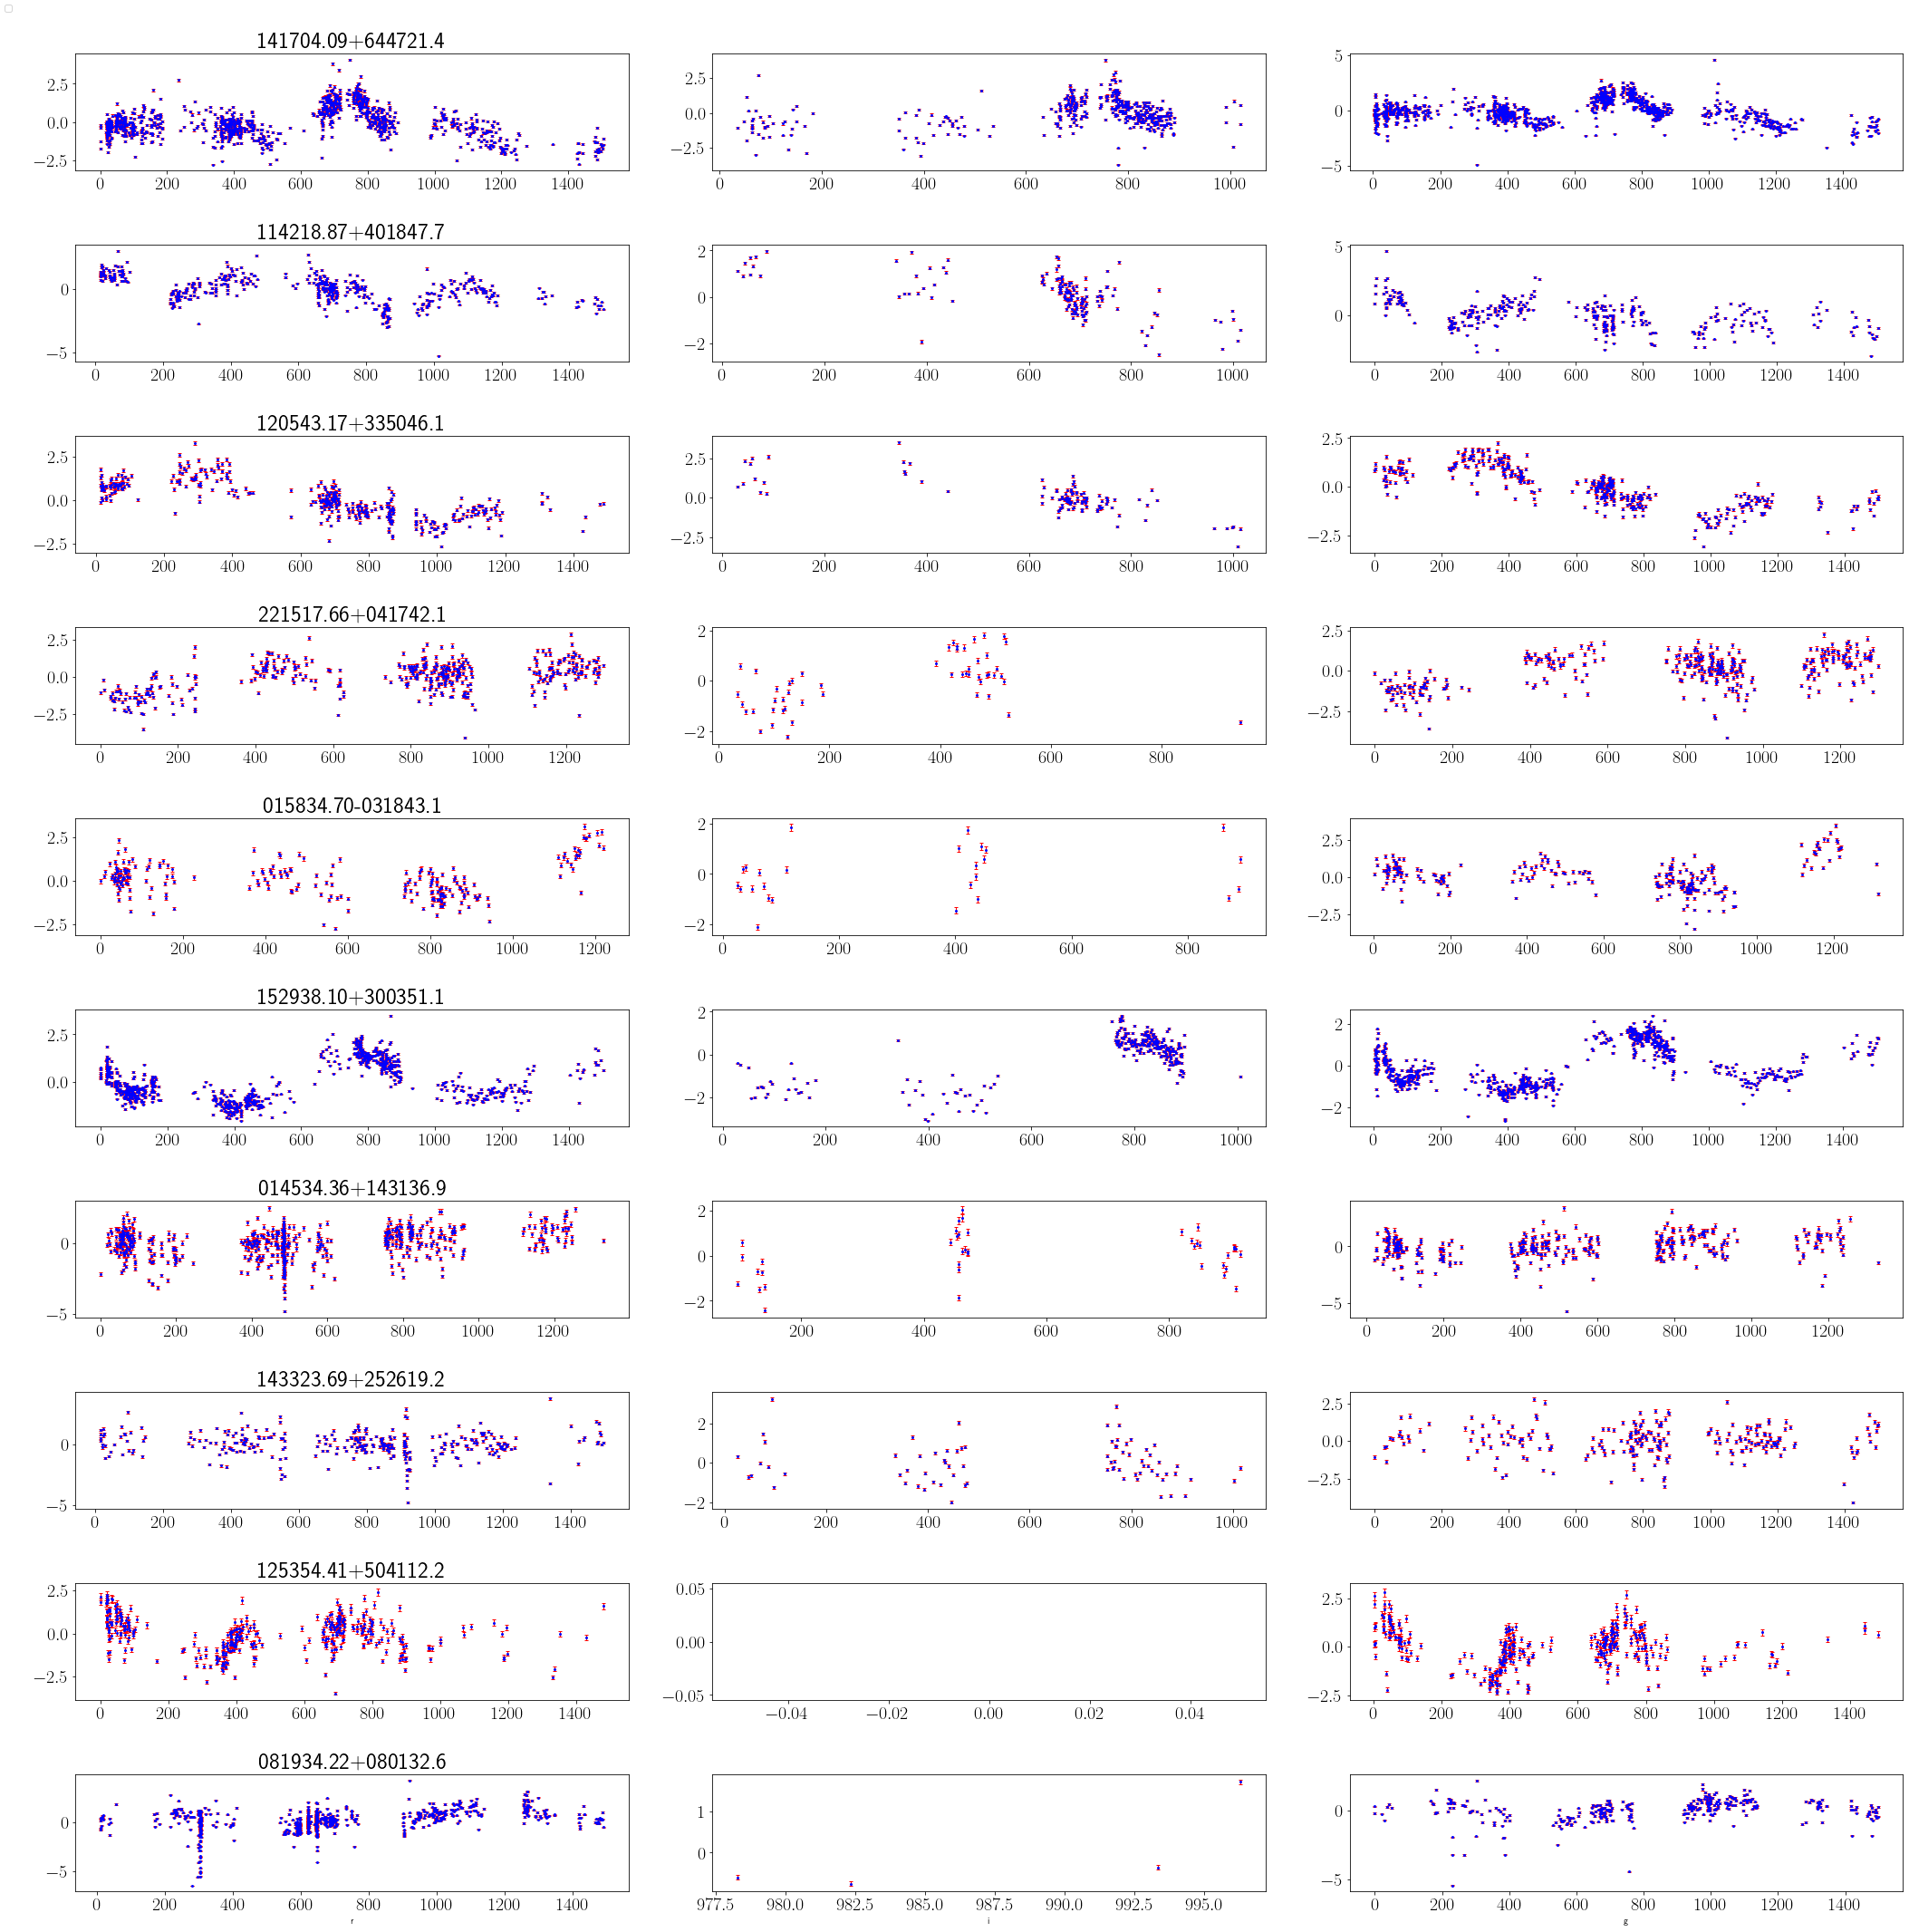

In [194]:
preview_lcs(lcs, n=10,figsize=(30,30))

## Peek at Light Curve Characteristics

In [90]:
folder = '../datasets/mZTF_DR_data'
min_length=1
sep=','
start_col=1
lcs = DataSet(name=folder, sep=sep, start_col=start_col)
band_folders = os.listdir(folder)
for band_folder in band_folders:
    band = band_folder.lower()
    lcs.add_band(band, os.path.join(folder, band_folder))
    ### preprocessing functions ##
lcs.filter(min_length=min_length)  
lcs.prune_outliers()  
#lcs.correct_z()
lcs.set_mean_mag()
lcs.set_sigma_nxs()
lcs.set_med_cadence()

validated 3398 files out of 3398 for band='r'
validated 3399 files out of 3399 for band='i'
validated 3399 files out of 3399 for band='g'


/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Text(0.5, 0, '$log_{10} \\, R_{EDD}$')

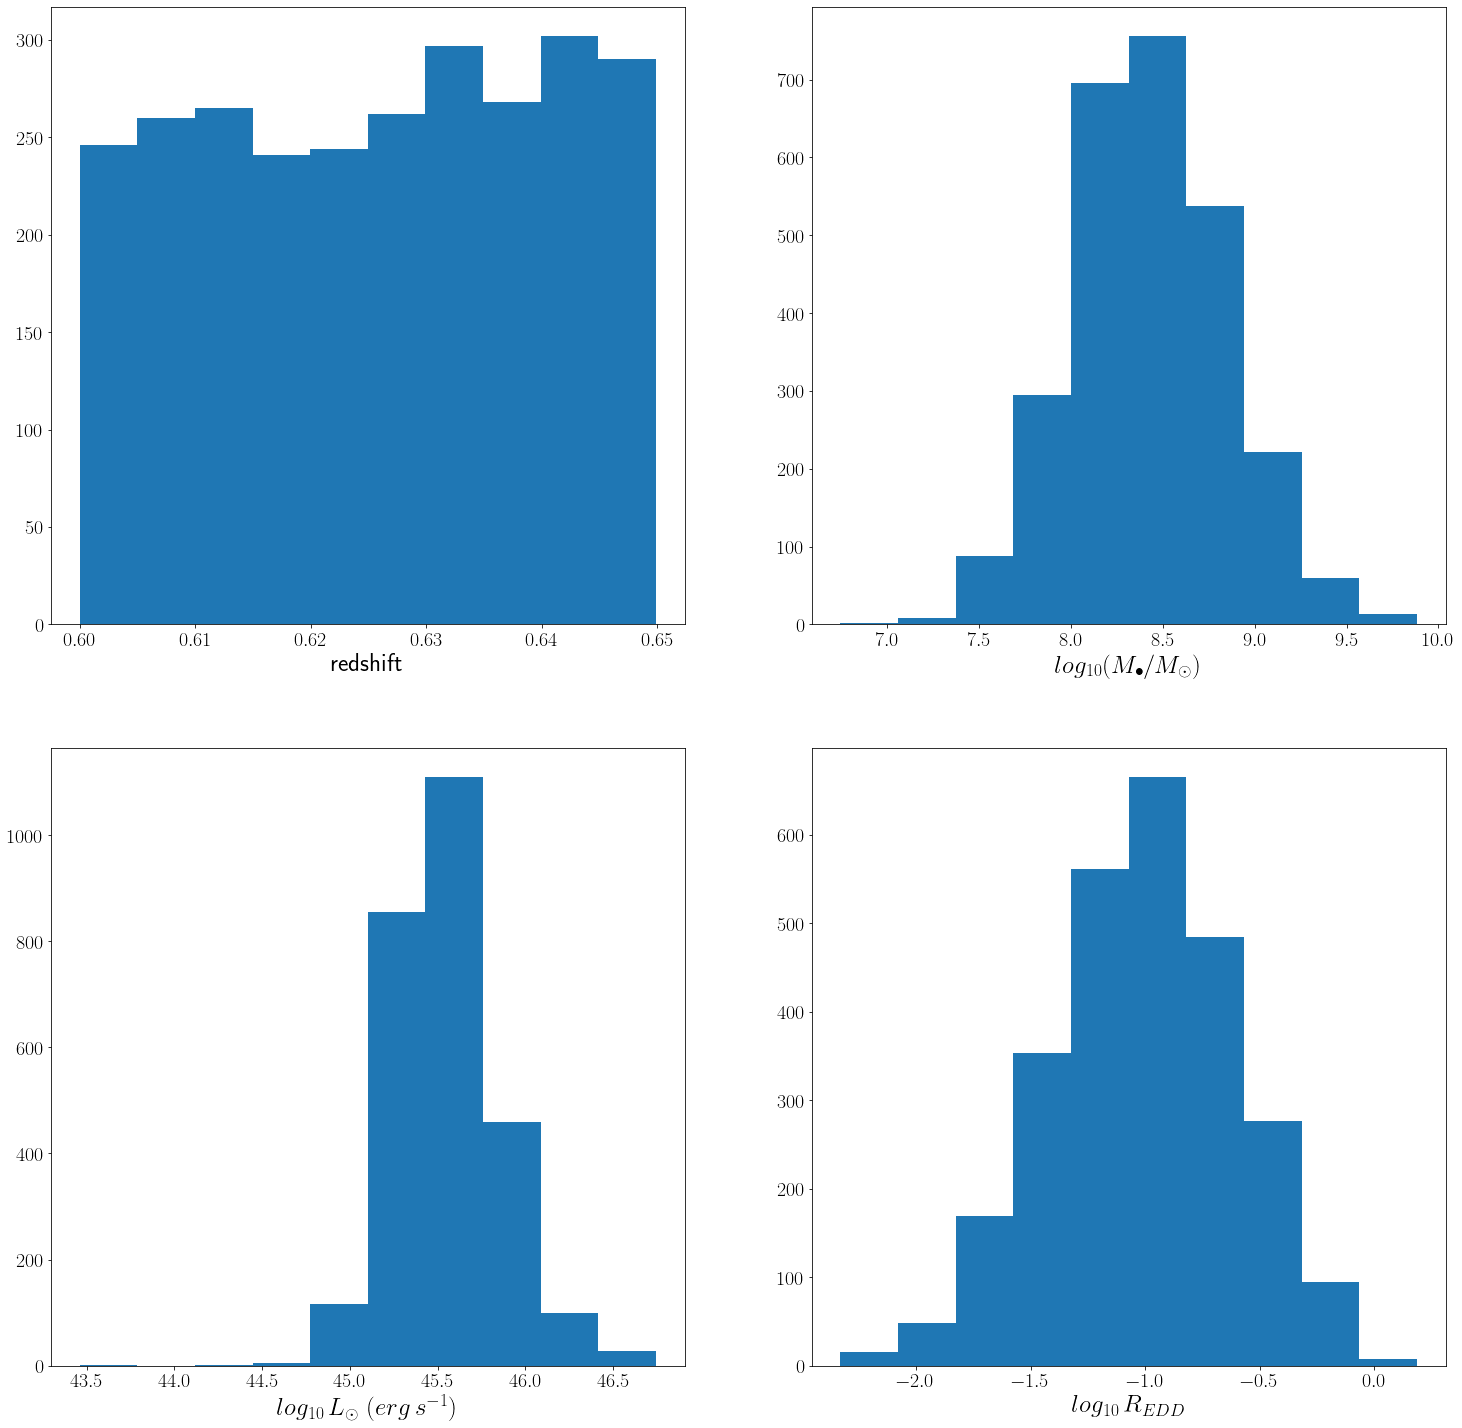

In [91]:
## associate phyiscal parameters from sample catalog with valid objs from dataset
sample_df = pd.read_csv('../datasets/catalogs/sample_cat')
sample_df = sample_df.set_index('SDSS')
locs = list(set(sample_df.index.values).intersection(set(lcs.valid_files_df.index.values)))
z = sample_df.loc[locs]['z'].values
log_mbh = sample_df.loc[locs]['logMBH'].values
log_lbol = sample_df.loc[locs]['logLbol'].values
log_redd = sample_df.loc[locs]['LogREdd'].values

plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
fig, ax = plt.subplots(2,2, figsize=(25,25))
fs = 25

rm_objs = pd.read_csv('../datasets/catalogs/rm_sample').loc[:,'z'].values
#zs = np.concatenate((rm_objs,z))
#bins = np.arange(np.max(zs), step=0.05)
ax[0][0].hist(z)
ax[0][0].set_xlabel(r'redshift', fontsize=fs)

ax[0][1].hist(log_mbh)
ax[0][1].set_xlabel(r'$log_{10}(M_{\bullet} / M_{\odot})$', fontsize=fs)

ax[1][0].hist(log_lbol)
ax[1][0].set_xlabel(r'$log_{10} \, L_{\odot} \ (erg\, s^{-1})$',fontsize=fs)

ax[1][1].hist(log_redd)
ax[1][1].set_xlabel(r'$log_{10} \, R_{EDD}$',fontsize=fs)

plt.savefig('img/phys_params_dist')

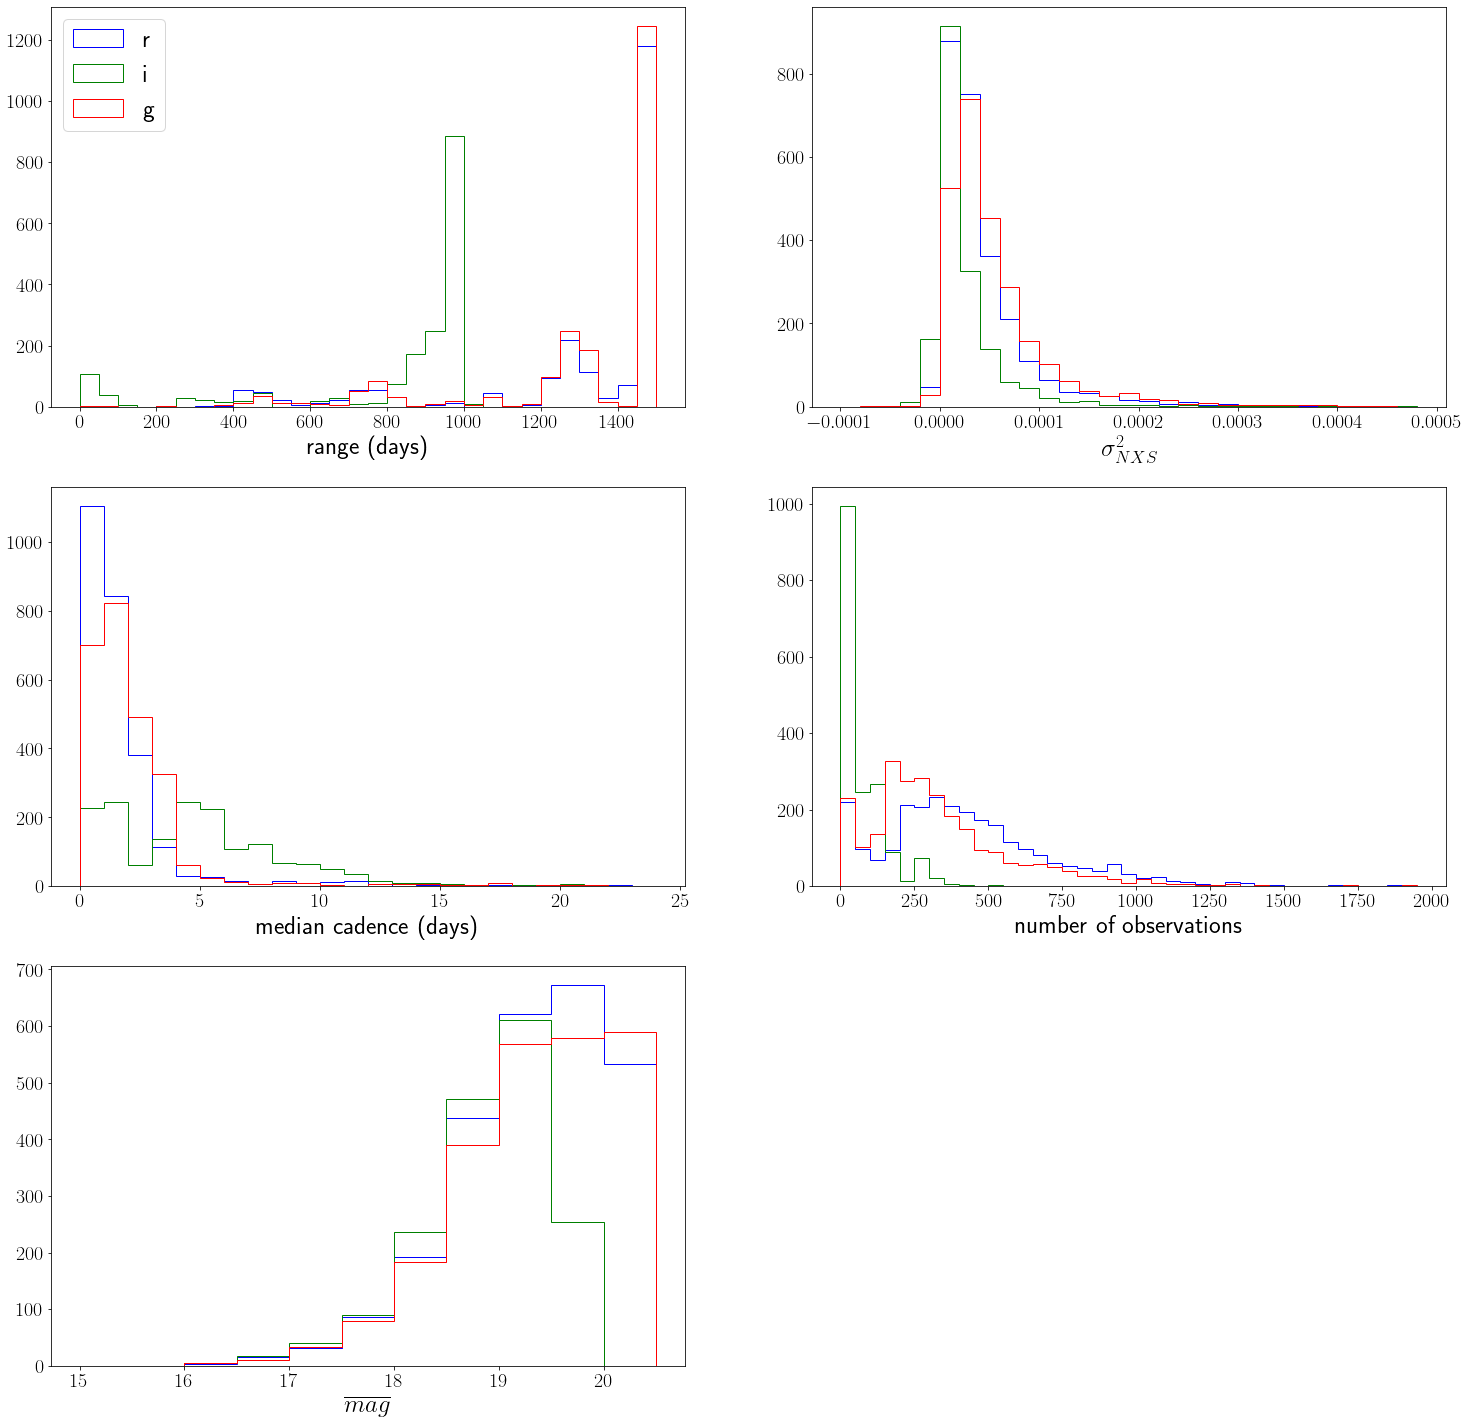

In [92]:
fig, ax = plt.subplots(3,2, figsize=(25,25))

means = lcs.mean_mag
## mean mags   
gtz_r = means[:,0] > 0 ## filter missing data 
gtz_i = means[:,1] > 0
gtz_g = means[:,2] > 0
bins = np.arange(15,np.max(means), step=0.5)
ax[2][0].hist(means[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[2][0].hist(means[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[2][0].hist(means[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[2][0].set_xlabel(r'$\overline{mag}$', fontsize=fs)

## range
ranges = np.array([np.ptp(lc[:,0]) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)
bins = np.arange(np.max(ranges), step=50)
ax[0][0].hist(ranges[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[0][0].hist(ranges[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[0][0].hist(ranges[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[0][0].legend(loc="upper left",fontsize=fs)
ax[0][0].set_xlabel(r'range (days)', fontsize=fs)

## med cadence
bins = np.arange(0,25,1)
ax[1][0].hist(lcs.med_cadence[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][0].set_xlabel(r'median cadence (days)',fontsize=fs)

## epochs 
l = np.array([len(lc) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)  
bins = np.arange(2000, step=50)
ax[1][1].hist(l[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][1].hist(l[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][1].hist(l[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][1].set_xlabel(r'number of observations', fontsize=fs)

bins = np.arange(-0.0001, 0.0005, step=0.00002)
ax[0][1].hist(lcs.sigma_nxs[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[0][1].set_xlabel(r'$\sigma^2_{NXS}$',fontsize=fs)

fig.delaxes(ax[2,1])

plt.savefig('img/sampledist')

### Count the number of missing light curves in each band

In [74]:
l = len(lcs.dataset)
lcs_per_obj = (means > 0).sum(axis=1)
one = (lcs_per_obj == 1).sum()
two = (lcs_per_obj == 2).sum()
three = (lcs_per_obj == 3).sum()
print(one, 'missing 2\n',
      two, 'missing 1\n',
      three, 'complete')
print(l-gtz_r.sum(), 'missing in r\n',
      l-gtz_i.sum(), 'missing in i\n',
      l-gtz_g.sum(), 'missing in g\n')

186 missing 2
 791 missing 1
 1698 complete
80 missing in r
 949 missing in i
 134 missing in g



## Light Curve Properties for RM Objects

In [105]:
folder = '../datasets/ZTF_rm'
min_length=1
sep=','
start_col=1
lcs = DataSet(name=folder, sep=sep, start_col=start_col)
band_folders = os.listdir(folder)
for band_folder in band_folders:
    band = band_folder.lower()
    lcs.add_band(band, os.path.join(folder, band_folder))
lcs.filter(min_length=min_length) 
lcs.prune_outliers()  
#lcs.correct_z()
lcs.set_mean_mag()
lcs.set_sigma_nxs()
lcs.set_med_cadence()

validated 9 files out of 9 for band='r'
validated 10 files out of 10 for band='i'
validated 10 files out of 10 for band='g'


/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [106]:
lcs.valid_files_df

,r,i,g
MCG+08-11-011,../datasets/ZTF_rm/r/MCG+08-11-011_DR_rband.csv,../datasets/ZTF_rm/i/MCG+08-11-011_DR_iband.csv,../datasets/ZTF_rm/g/MCG+08-11-011_DR_gband.csv
NGC2617,../datasets/ZTF_rm/r/NGC2617_DR_rband.csv,../datasets/ZTF_rm/i/NGC2617_DR_iband.csv,../datasets/ZTF_rm/g/NGC2617_DR_gband.csv
3C120,../datasets/ZTF_rm/r/3C120_DR_rband.csv,../datasets/ZTF_rm/i/3C120_DR_iband.csv,../datasets/ZTF_rm/g/3C120_DR_gband.csv
NGC5548,../datasets/ZTF_rm/r/NGC5548_DR_rband.csv,../datasets/ZTF_rm/i/NGC5548_DR_iband.csv,../datasets/ZTF_rm/g/NGC5548_DR_gband.csv
Mrk876,../datasets/ZTF_rm/r/Mrk876_DR_rband.csv,../datasets/ZTF_rm/i/Mrk876_DR_iband.csv,../datasets/ZTF_rm/g/Mrk876_DR_gband.csv
H2106-099,../datasets/ZTF_rm/r/H2106-099_DR_rband.csv,../datasets/ZTF_rm/i/H2106-099_DR_iband.csv,../datasets/ZTF_rm/g/H2106-099_DR_gband.csv
Mrk142,../datasets/ZTF_rm/r/Mrk142_DR_rband.csv,../datasets/ZTF_rm/i/Mrk142_DR_iband.csv,../datasets/ZTF_rm/g/Mrk142_DR_gband.csv
Mrk817,../datasets/ZTF_rm/r/Mrk817_DR_rband.csv,../datasets/ZTF_rm/i/Mrk817_DR_iband.csv,../datasets/ZTF_rm/g/Mrk817_DR_gband.csv


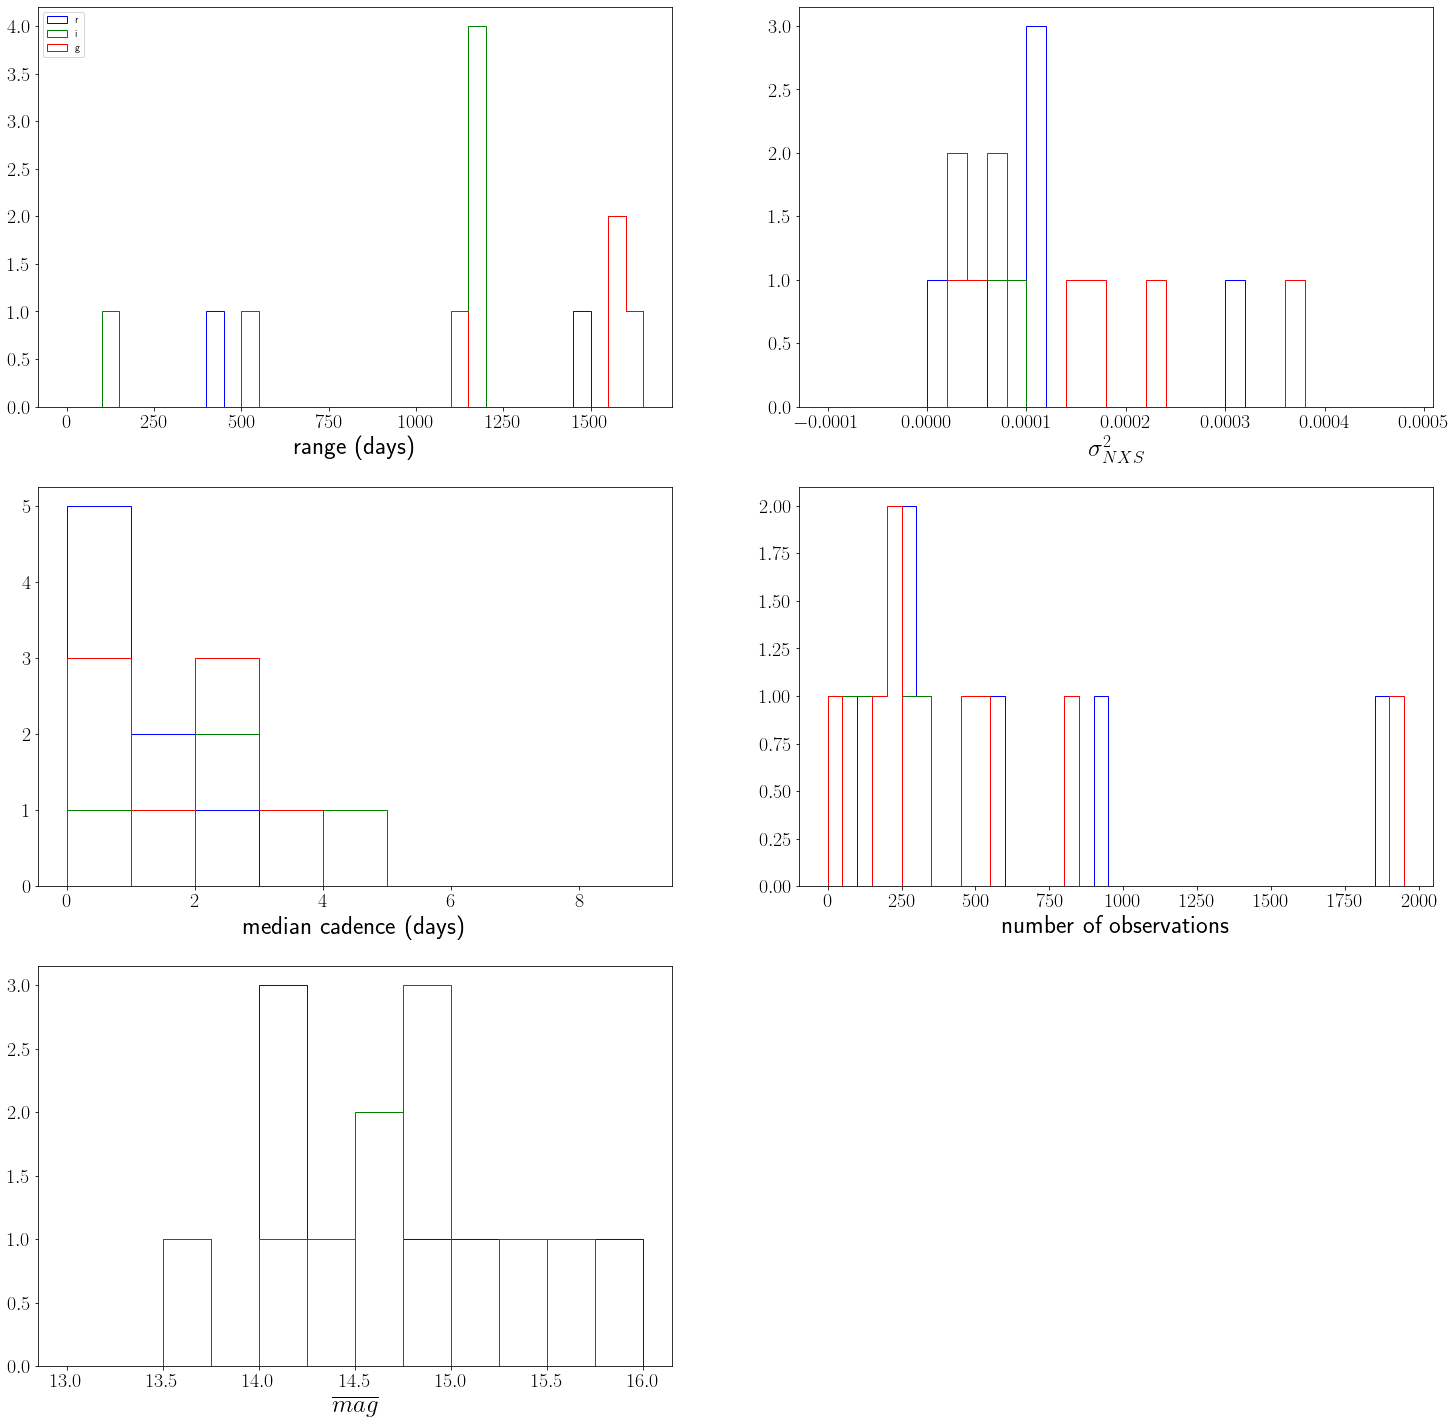

In [110]:
fig, ax = plt.subplots(3,2, figsize=(25,25))

means = lcs.mean_mag
## mean mags   
gtz_r = means[:,0] > 0 ## filter missing data 
gtz_i = means[:,1] > 0
gtz_g = means[:,2] > 0
bins = np.arange(13,np.max(means), step=0.25)
ax[2][0].hist(means[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[2][0].hist(means[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[2][0].hist(means[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[2][0].set_xlabel(r'$\overline{mag}$', fontsize=fs)

## range
ranges = np.array([np.ptp(lc[:,0]) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)
bins = np.arange(np.max(ranges), step=50)
ax[0][0].hist(ranges[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[0][0].hist(ranges[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[0][0].hist(ranges[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[0][0].legend(loc="upper left")
ax[0][0].set_xlabel(r'range (days)', fontsize=fs)

## med cadence
bins = np.arange(0,10,1)
ax[1][0].hist(lcs.med_cadence[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][0].hist(lcs.med_cadence[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][0].set_xlabel(r'median cadence (days)',fontsize=fs)

## epochs 
l = np.array([len(lc) for object_lcs in lcs.dataset for lc in object_lcs]).reshape(-1,3)   
bins = np.arange(2000, step=50)
ax[1][1].hist(l[gtz_r,0],label='r',bins=bins, edgecolor='blue',histtype=u'step')
ax[1][1].hist(l[gtz_i,1],label='i',bins=bins,edgecolor='green',histtype=u'step')
ax[1][1].hist(l[gtz_g,2],label='g',bins=bins,edgecolor='red',histtype=u'step')
ax[1][1].set_xlabel(r'number of observations', fontsize=fs)

## normalized xs variance
bins = np.arange(-0.0001, 0.0005, step=0.00002)
ax[0][1].hist(lcs.sigma_nxs[gtz_r,0],bins=bins,label='r', edgecolor='blue',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_i,1],bins=bins,label='i',edgecolor='green',histtype=u'step')
ax[0][1].hist(lcs.sigma_nxs[gtz_g,2],bins=bins,label='g',edgecolor='red',histtype=u'step')
ax[0][1].set_xlabel(r'$\sigma^2_{NXS}$',fontsize=fs)

fig.delaxes(ax[2,1])

plt.savefig('img/rm_objs_dist')

In [111]:
l = len(lcs.dataset)

lcs_per_obj = (means > 0).sum(axis=1)
one = (lcs_per_obj == 1).sum()
two = (lcs_per_obj == 2).sum()
three = (lcs_per_obj == 3).sum()

print(one, 'missing 2\n',
      two, 'missing 1\n',
      three, 'complete')
print(l-gtz_r.sum(), 'missing in r\n',
      l-gtz_i.sum(), 'missing in i\n',
      l-gtz_g.sum(), 'missing in g\n')

0 missing 2
 3 missing 1
 5 complete
0 missing in r
 3 missing in i
 0 missing in g



In [4]:
print('Intra-example formatting:\n')

print('light curve g\n')
print('  t    mag  magerr')
print(np.array([[0,4.3,0.09],
        [1.2,5.2,0.08]]))
print('\n')
print('light curve r\n')
print(np.array([[0,3.2,0.12],
        [2.33,4.1,0.03]]))
print('\n')
print('becomes:\n')
print('light curve g\n')
print(np.array([[0,4.3,0.09],
        [1.2,5.2,0.08],
        [2.33,0,0]]))
print('\n')
print('light curve r\n')
print(np.array([[0,3.2,0.12],
                [1.2,0.0,0.00],[2.33,4.1,0.03]]))
print('\nif 5 is the length of the longest \nintra-example union-time array, becomes:\n')
print('light curve g\n')
print(np.array([[0,4.3,0.09],
        [1.2,5.2,0.08],
        [2.33,0,0],[0,0,0],[0,0,0]]))
print('\n')
print('light curve r\n')
print(np.array([[0,3.2,0.12],
                [1.2,0.0,0.00],[2.33,4.1,0.03],[0,0,0],[0,0,0]]))


Intra-example formatting:

light curve g

  t    mag  magerr
[[0.   4.3  0.09]
 [1.2  5.2  0.08]]


light curve r

[[0.   3.2  0.12]
 [2.33 4.1  0.03]]


becomes:

light curve g

[[0.   4.3  0.09]
 [1.2  5.2  0.08]
 [2.33 0.   0.  ]]


light curve r

[[0.   3.2  0.12]
 [1.2  0.   0.  ]
 [2.33 4.1  0.03]]

if 5 is the length of the longest 
intra-example union-time array, becomes:

light curve g

[[0.   4.3  0.09]
 [1.2  5.2  0.08]
 [2.33 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]


light curve r

[[0.   3.2  0.12]
 [1.2  0.   0.  ]
 [2.33 4.1  0.03]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
